In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('train.csv', index_col=0)

### First data assessment

- 14 continuous features, all between 0 and 1
- A continuous target value
- 300000 entries
- No missing values

In [3]:
df.head(3)

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
id,,,,,,,,,,,,,,,
1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 1 to 499999
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cont1   300000 non-null  float64
 1   cont2   300000 non-null  float64
 2   cont3   300000 non-null  float64
 3   cont4   300000 non-null  float64
 4   cont5   300000 non-null  float64
 5   cont6   300000 non-null  float64
 6   cont7   300000 non-null  float64
 7   cont8   300000 non-null  float64
 8   cont9   300000 non-null  float64
 9   cont10  300000 non-null  float64
 10  cont11  300000 non-null  float64
 11  cont12  300000 non-null  float64
 12  cont13  300000 non-null  float64
 13  cont14  300000 non-null  float64
 14  target  300000 non-null  float64
dtypes: float64(15)
memory usage: 36.6 MB


### Train test split

In [5]:
target_list = ['target']
feature_list = df.columns.drop(target_list).to_list()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_list], df[target_list], test_size=0.3, random_state=21)

### Create a baseline

In [13]:
def print_results(y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    print(f"{model_name} mean squared error: {mse:.2}")
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} r2-score: {r2:.2}, which is a {r2:.2}% reduction in residuals compared to the uniform average")
    return mse, r2

In [14]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse_baseline, r2_baseline = print_results(y_pred, "base_line")

base_line mean squared error: 0.53
base_line r2-score: 0.019, which is a 0.019% reduction in residuals compared to the uniform average


### Visualizing relationships of dependent and independent values
- No clear correlation visible for specific input-target combinations; 'horizontal shape of the plots'
- Some input value regions seem to have more target values than others, e.g. view `cont2`. This is different per feature

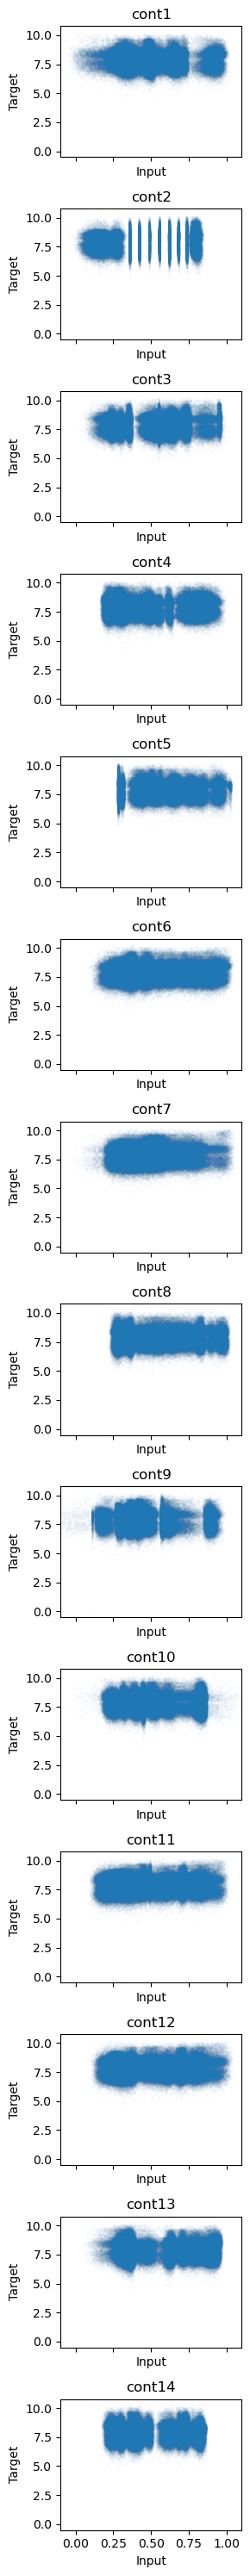

In [8]:
fig, ax = plt.subplots(len(feature_list), 1, figsize = (3, 30), sharex=True)

for i in range(len(feature_list)):
    ax[i].scatter(x = df[feature_list[i]].values, y = df[target_list], alpha = 0.01, s= 1)
    ax[i].set_title(f"{feature_list[i]}")
    ax[i].set_xlabel('Input')
    ax[i].set_ylabel('Target')
    ax[i].set_xlim(-0.1, 1.1)

plt.tight_layout()

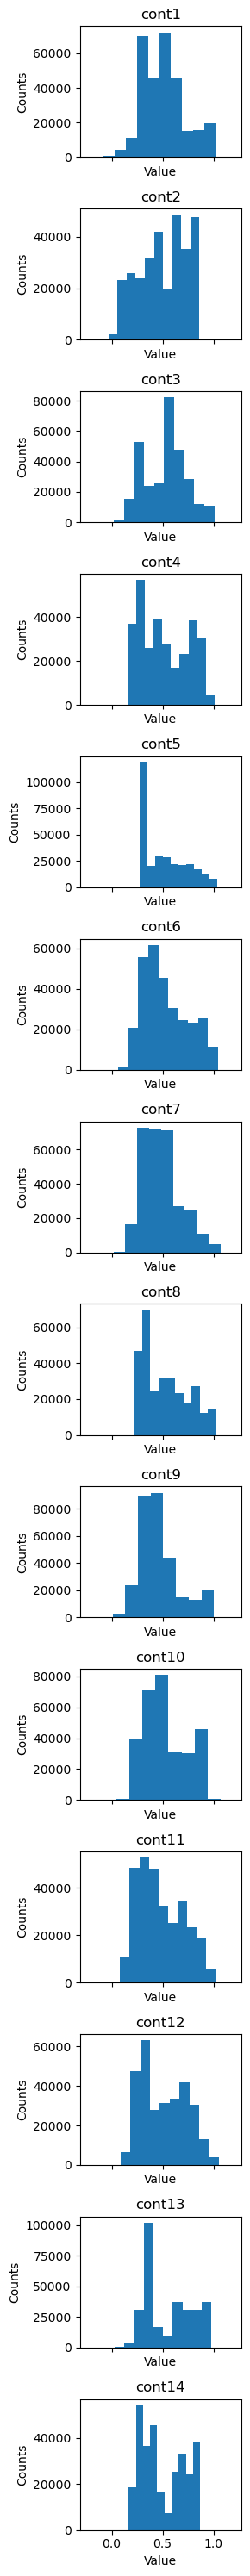

In [12]:
fig, ax = plt.subplots(len(feature_list), 1, figsize = (3, 30), sharex=True)


for i in range(len(feature_list)):
    ax[i].hist(df[feature_list[i]].values)
    ax[i].set_title(f"{feature_list[i]}")
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Counts')

plt.tight_layout()